In [5]:
import json
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../../utils/')
import biotite_utils
import dataset_utils
from  biotite.sequence import ProteinSequence

def count_amino_acid_types(dataset):
    binding_amino_acids = {'ALA': 0, 'ARG': 0, 'ASN': 0, 'ASP': 0, 'CYS': 0, 'GLN': 0, 'GLU': 0, 'GLY': 0, 'HIS': 0, 'ILE': 0, 'LEU': 0, 'LYS': 0, 'MET': 0, 'PHE': 0, 'PRO': 0, 'SER': 0, 'THR': 0, 'TRP': 0, 'TYR': 0, 'VAL': 0}
    nonbinding_amino_acids = {'ALA': 0, 'ARG': 0, 'ASN': 0, 'ASP': 0, 'CYS': 0, 'GLN': 0, 'GLU': 0, 'GLY': 0, 'HIS': 0, 'ILE': 0, 'LEU': 0, 'LYS': 0, 'MET': 0, 'PHE': 0, 'PRO': 0, 'SER': 0, 'THR': 0, 'TRP': 0, 'TYR': 0, 'VAL': 0}
    
    for id, binding_residues in dataset.items():
        if id == '8j1kA': continue # skip 8j1kA, it throws some weird error I don't want to debug

        # print(f'Processing {id} ...')
        
        protein = biotite_utils.load_structure(id)
        chain_id = id[4:]
        protein_structure = biotite_utils.get_protein_backbone(protein, chain_id)
        
        for residue in protein_structure:
            if residue.res_id in binding_residues:
                binding_amino_acids[residue.res_name] += 1
            else:
                nonbinding_amino_acids[residue.res_name] += 1
    return binding_amino_acids, nonbinding_amino_acids
   

In [7]:
DATASET = 'rigid-dataset'
DATASET_PATH = f'../../../datasets/{DATASET}'
rigid_ids = dataset_utils.get_annotations(DATASET_PATH)
rigid_binding_amino_acids, rigid_nonbinding_amino_acids = count_amino_acid_types(rigid_ids)

DATASET = 'cryptobench-dataset'
DATASET_PATH = f'../../../datasets/{DATASET}'
cryptobench_ids = dataset_utils.get_annotations(DATASET_PATH)
cryptobench_binding_amino_acids, cryptobench_nonbinding_amino_acids = count_amino_acid_types(cryptobench_ids)


In [28]:
{key: cryptobench_nonbinding_amino_acids[key] + rigid_binding_amino_acids[key]  for key in cryptobench_nonbinding_amino_acids.keys()}

{'ALA': 19044,
 'ARG': 11689,
 'ASN': 9505,
 'ASP': 13564,
 'CYS': 2877,
 'GLN': 8550,
 'GLU': 15082,
 'GLY': 16815,
 'HIS': 5397,
 'ILE': 12912,
 'LEU': 21394,
 'LYS': 13165,
 'MET': 4880,
 'PHE': 9490,
 'PRO': 11149,
 'SER': 13283,
 'THR': 12259,
 'TRP': 3484,
 'TYR': 8234,
 'VAL': 16404}

64.73968167831879


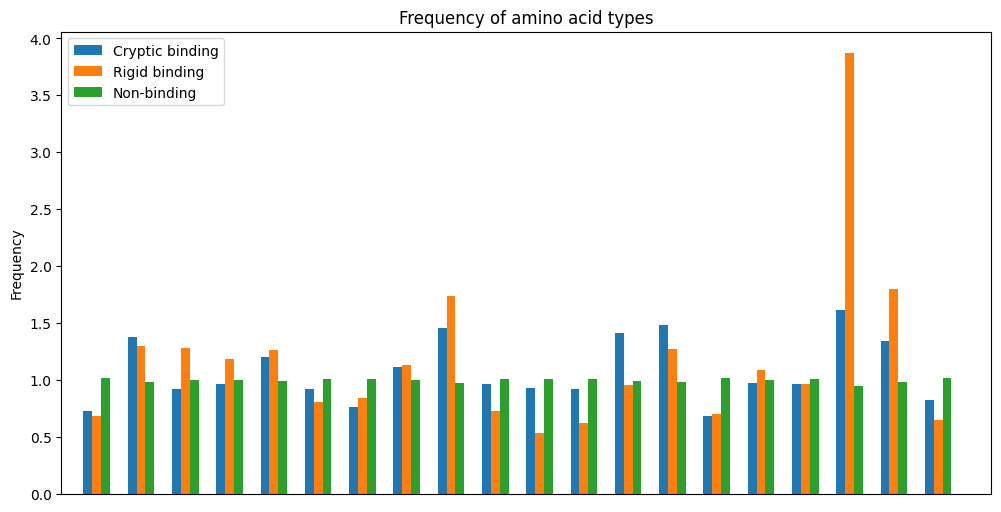

In [20]:
colorblind_palette = ['#000000', '#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7']

import biotite

def normalize(original_list):
    list_sum = sum(original_list)
    return np.array([i / list_sum for i in original_list])

def make_histogram(datasets, labels, title="Frequency of amino acid types"):
    amino_acids = datasets[0].keys()
    plt.figure(figsize=(12, 6))

    total = [datasets[0][key] + datasets[1][key] + datasets[2][key]  for key in datasets[0].keys()]
    total_hist = normalize(total)
    
    sum = 0
    X_axis = np.arange(len(amino_acids))

    for i, (dataset, label) in enumerate(zip(datasets,labels)):
        hist = [dataset[ii] for ii in amino_acids] # hist je pocet dane aminokyseliny (napr ALA) v datasetu (napr. cryptic)
        hist = normalize(hist) / total_hist
        sum += np.sum(hist)
        shift = -0.4 + (i * 0.2)
        plt.bar(X_axis + shift, hist, 0.2, label=label) #, color=colorblind_palette[i + 4])

    print(sum)
    labels = [f'{biotite.structure.info.full_name(i)} ({i})' for i in amino_acids]
    # plt.xticks(X_axis - 0.2, labels, rotation=-90) 
    plt.xticks([])
    plt.xlim(-1, len(amino_acids))
    plt.ylabel("Frequency") 
    plt.title(title) 
    plt.legend(loc = "upper left")
    plt.show()     

make_histogram([cryptobench_binding_amino_acids, rigid_binding_amino_acids, {key: cryptobench_nonbinding_amino_acids[key] + rigid_nonbinding_amino_acids[key]  for key in cryptobench_nonbinding_amino_acids.keys()}],
               ['Cryptic binding', 'Rigid binding', 'Non-binding'])

(nejen frustrace ale vse) udelat t-test - jestli je rozdil frekvenci stat. vyznamny ( i do grafu)
frustrace + cons - pridat i rigid nejenom cryptobench


In [8]:
import os

def get_distance_path(dataset):
    return f'/home/vit/Projects/flexibility-analysis/data/features/residue-distances/{dataset}'

def count_binned_amino_acid_types(dataset, dataset_name, bins, labels):
    binding_amino_acids = {bin: {'ALA': 0, 'ARG': 0, 'ASN': 0, 'ASP': 0, 'CYS': 0, 'GLN': 0, 'GLU': 0, 'GLY': 0, 'HIS': 0, 'ILE': 0, 'LEU': 0, 'LYS': 0, 'MET': 0, 'PHE': 0, 'PRO': 0, 'SER': 0, 'THR': 0, 'TRP': 0, 'TYR': 0, 'VAL': 0} for bin in labels}
    nonbinding_amino_acids = {bin: {'ALA': 0, 'ARG': 0, 'ASN': 0, 'ASP': 0, 'CYS': 0, 'GLN': 0, 'GLU': 0, 'GLY': 0, 'HIS': 0, 'ILE': 0, 'LEU': 0, 'LYS': 0, 'MET': 0, 'PHE': 0, 'PRO': 0, 'SER': 0, 'THR': 0, 'TRP': 0, 'TYR': 0, 'VAL': 0} for bin in labels}
    
    for id, binding_residues in dataset.items():
        if id == '8j1kA': continue # skip 8j1kA, it throws some weird error I don't want to debug

        # print(f'Processing {id} ...')
        
        protein = biotite_utils.load_structure(id)
        chain_id = id[4:]
        protein_structure = biotite_utils.get_protein_backbone(protein, chain_id)
        distances_path = get_distance_path(dataset_name)
        if not os.path.exists(f'{distances_path}/{id}.npy'):
            continue
        distances = np.load(f'{distances_path}/{id}.npy')

        if len(distances) != len(protein_structure):
            print(f'Length mismatch for {id}')
            continue
        for distance, residue in zip(distances, protein_structure):
            residue_name = residue.res_name
            # check which bin the distance of the residue falls into
            for i, bin in enumerate(bins):
                if bins[i] < distance <= bins[i+1]:
                    if residue.res_id in binding_residues:
                        # TODO
                        binding_amino_acids[labels[i]][residue_name] += 1
                    else:
                        nonbinding_amino_acids[labels[i]][residue_name] += 1
                    break
    return binding_amino_acids, nonbinding_amino_acids


    # return binding_amino_acids, nonbinding_amino_acids

bins = [0, 2, 4, 8, np.inf]
labels = ['[0, 2]', '[2, 4]', '[4, 8]', '[8, inf]']


DATASET = 'rigid-dataset'
DATASET_PATH = f'../../../datasets/{DATASET}'
binned_rigid_binding_amino_acids, binned_rigid_nonbinding_amino_acids = count_binned_amino_acid_types(rigid_ids, DATASET, bins, labels)


DATASET = 'cryptobench-dataset'
DATASET_PATH = f'../../../datasets/{DATASET}'
binned_cryptobench_binding_amino_acids, binned_cryptobench_nonbinding_amino_acids = count_binned_amino_acid_types(cryptobench_ids, DATASET, bins, labels)



64.58318769616454


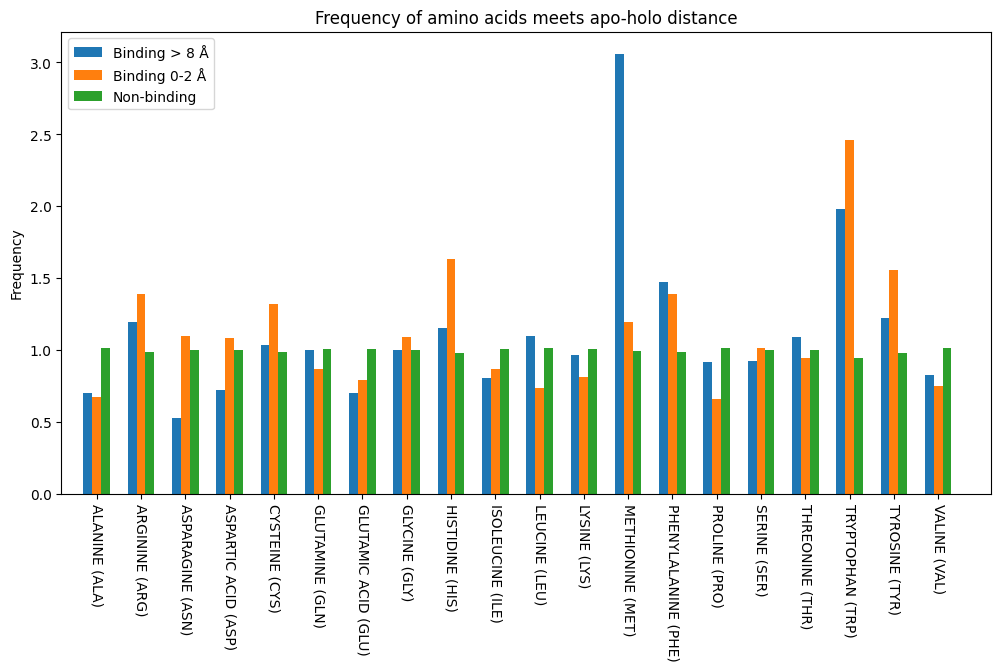

In [19]:

make_histogram([{key: binned_cryptobench_binding_amino_acids['[8, inf]'][key] + binned_rigid_binding_amino_acids['[8, inf]'][key]  for key in binned_cryptobench_binding_amino_acids['[8, inf]'].keys()},
                # {key: binned_cryptobench_binding_amino_acids['[4, 8]'][key] + binned_rigid_binding_amino_acids['[4, 8]'][key]  for key in binned_cryptobench_binding_amino_acids['[4, 8]'].keys()},
                # {key: binned_cryptobench_binding_amino_acids['[2, 4]'][key] + binned_rigid_binding_amino_acids['[2, 4]'][key]  for key in binned_cryptobench_binding_amino_acids['[2, 4]'].keys()},
                {key: binned_cryptobench_binding_amino_acids['[0, 2]'][key] + binned_rigid_binding_amino_acids['[0, 2]'][key]  for key in binned_cryptobench_binding_amino_acids['[0, 2]'].keys()},
                {key: binned_cryptobench_nonbinding_amino_acids['[0, 2]'][key] + binned_rigid_nonbinding_amino_acids['[0, 2]'][key] + binned_cryptobench_nonbinding_amino_acids['[8, inf]'][key] + binned_rigid_nonbinding_amino_acids['[8, inf]'][key]
                   for key in binned_cryptobench_nonbinding_amino_acids['[0, 2]'].keys()}],
               ['Binding > 8 Å', 'Binding 0-2 Å', 'Non-binding'],title="Frequency of amino acids meets apo-holo distance")
